## Implementation of LSTM (RNN) - Recurrent Neural Networks to predict stock prices for Google.


We are going to train our LSTM model on five years of the Google stock price, and this is from the beginning of 2012 to the end of 2016 and then, based on this training, based on the correlations identified or captured by the LSTM of the Google stock price, we will try to predict the first month of 2017. We're gonna try to predict January 2017. And again, we're not going to try to predict exactly the stock price, we're gonna try to predict the trend, the upward or downward trend of the Google stock price.

In [8]:
# Necessary Library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load the training dataset

In [9]:
df_train = pd.read_csv("resources/Google_Stock_Price_Train.csv")

df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [10]:
# Check for missing values
sum(df_train.isna().sum())

0

In [11]:
# Lets work out some summary statistics
df_train.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


Text(0.5, 1.0, 'Open Prices for the Stock')

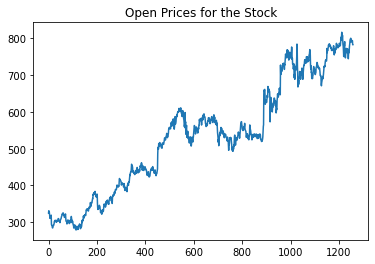

In [12]:
# Lets visualize the Open Price
df_train['Open'].plot()
plt.title("Open Prices for the Stock")

In [13]:
# Now we will select the right columns - we are only interested in the Open price column
# In order to select only column 1 - we mark it as 1:2, so that it gets returned as numpy array, else it will be retured as 
# pandas core series

training_set = np.array(df_train.iloc[:, 1:2])

### Feature Scaling of the data

Lets just recall, there are two ways of feature scaling - standardisation and Normalisation

<img src="resources/Annotation 2019-11-04 222418.png" />

Whenever we build RNN and especially if there is a sigmoid function as the activation function in the output layer of you recurrent neural network, well I recommend to apply normalization.

In [14]:
from sklearn.preprocessing import MinMaxScaler

# all the new scaled stock prices will be between 0 and 1
sc = MinMaxScaler(feature_range=(0, 1))

# Now we apply this scaler object to our training set
# The fit will compute the min and max from the training set and transform will scale it accordingly
training_set_scaled = sc.fit_transform(training_set)

training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

### Data Pre-processing

As a next step, we will be about creating a specific data structure, that's the most important step actually of data
pre-processing for recurrent neural networks. We're going to create a data structure specifying what the RNN will need to remember when predicting the next stock price. And this is called the number of time steps. This is super important to have the right number of time steps because a wrong number of time steps could lead to over fitting or nonsense predictions.

Creating a data structure with <em>60 timesteps and 1 output</em>. <br>
Okay, so 60 timesteps means that at each time T, the RNN is going to look at the 60 stock prices before time T, that is the stock prices between 60 days before time T and time T, and based on the trends, it is capturing during these 60 previous timesteps, it will try to predict the next output. So 60 timesteps of the past information from which our RNN is gonna try to learn and understand some correlations, or some trends, and based on its understanding, it's going to try to predict the next output. That is, the stock price at time T plus one. So that's very important to understand. 60 is a number that I experimented, trying different number of time steps.<br><br>
And the 60 timesteps correspond of course to the 60 previous financial days, and since there 20 financial days in one month,
well 60 timesteps correspond to three months. So that means that each day we're gonna look at the three previous month to try to predict the stock price the next day.

Well since we're gonna get at each time T the 60 preview stock prices, well we can only start doing this from the 60th stock price of our dataset. That is, the stock price of the 60th financial day of 2012, because we're gonna get the 60 previews stock prices before that stock price, and therefore I need to start the for loop with 60, because then for each i, which is the index of the stock price observation, I'm gonna get the range from i minus 60 to i, which exactly contains the 60 preview stock prices efore the stock price at time T. o that's why I'm starting the range at 60, nd then good news, the upper bound
is much more natural and easy to find. t's of course the last index of our observation, hat is 1,257, but it's not 57, it's actually 1258 because remember the upper bound is excluded in a range. So we have to go up to 1258, which is also the size of the array. <br> <br>
So that's exactly the idea of the RNN. It is memorizing what's happening in the 60 previous timesteps to predict the next value at time T plus one, the next stock price at time T plus one.

In [15]:
# We need to create two entities.. So basically for each observation, that is for each financial day, 
# X_train will contain the 60 previews stock prices, before that financial day, and y_train will contain the 
# stock price the next financial day.
# We need to do this for every Time T

# Lets decalare some variables now
timestamp = 60
upperbound = len(training_set_scaled)

# Inputs and output for the neural network
X_train = []
y_train = []

for index in range(timestamp, upperbound):
    X_train.append(training_set_scaled[index-timestamp:index, 0])
    y_train.append(training_set_scaled[index, 0])

# Now we need to convert this into numpy arrays so that it is accepted by our RNN
X_train, y_train = np.array(X_train), np.array(y_train)

# Now lets look at X_train
print(X_train)

# The First element corresponds to scaled stock prices from index 0 to 59
# The second element corresponds to scaled stock prices from index 1 to 60 and so on....

print("\n")
# Lets view y_train
print(y_train)

# The first element is the stock price for index 60 for corresponding X_train values of 0 to 59

[[0.08581368 0.09701243 0.09433366 ... 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 ... 0.08034452 0.08497656 0.08627874]
 [0.09433366 0.09156187 0.07984225 ... 0.08497656 0.08627874 0.08471612]
 ...
 [0.92106928 0.92438053 0.93048218 ... 0.95475854 0.95204256 0.95163331]
 [0.92438053 0.93048218 0.9299055  ... 0.95204256 0.95163331 0.95725128]
 [0.93048218 0.9299055  0.93113327 ... 0.95163331 0.95725128 0.93796041]]


[0.08627874 0.08471612 0.07454052 ... 0.95725128 0.93796041 0.93688146]


### Reshaping

Reshaping is all aboout adding some more dimensionality. And this dimension we're gonna add is exactly the unit, that is, the number of predictors we can use to predict what we want. Which is the Google Stock Price at time T plus one. So in the scope of this financial engineering problem where we try to predict the trend of the Google Stock Price,
these predictors are indicators. <br><br>
So that's our only indicator, but thanks to this new dimension that we're gonna add to our data structure. We will be able to add some more indicators, if you think could help predict even better the upward and downward trends of the Google Stock Price. We're not gonna do it in this implementation. We will just use the open Google Stock Price.

In [16]:
X_train.shape

(1198, 60)

First, the batch size, which will correspond to the total number of observations we have. That is the total number of stock prices we have from 2012 to the end of 2016.<br>

Then the second dimension is the time steps, the number of time steps. And that is, as you understood, 60.<br>

And now the third dimension, this new one that we're adding is the one corresponding to the indicators, the predictors. So I remind, these can be some new financial indicators that could help predict the Google stock price trends. So, for example, that can be the closed Google stock price or even some other stock prices from other companies. I'll give you another example that explains this well. Take Apple and Samsung, you know that in an iPhone most of the material is coming from Samsung. And therefore Apple is highly dependent on Samsung, but at the same time, Samsung is highly dependent on Apple, because simply, Apple is their best customer. And therefore the stock prices of Apple and Samsung might be highly correlated.
And that's exactly what you could add as a new dimension if you want to predict the Apple stock price. Because simply the Apple stock price is very likely correlated to the Samsung stock price.

So there we go, we have our three dimensions. First the number of observations, or the batch size if you do some batch training. Then the number of time steps, 60. And then the number of indicators we have, which in our case, will be one.

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

### Building the RNN

In [18]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [19]:
# Import the needed libraries

import tensorflow as tf
from datetime import datetime

The <em>LSTM function</em> takes various arguments
* <em>units</em> - Number of LSTM cells or units we want to have in this LSTM layer
* <em>returnSequences (True)</em> - because we are building a stacked LSTM which therefore will have several LSTM layers and when you add another LSTM layer after the one you are creating right now, well you have to set the return sequences argument to true. Once you are done with your LSTM layers, you are not gonna add another one after that, you will set it equal to false, but you won't even have to do this because this is the default value of the return sequences parameter.
* input_shape - in the last step of the data preprocessing part. It's an input shape in three dimensions, in 3-D, corresponding to the observations, the time steps, and the indicators. But in this third argument of the LSTM class, we won't have to include the three dimensions, only the two last ones corresponding to the time steps and the indicators, because the first one, corresponding to the observations, it will be automatically taken into account.

In [20]:
# Initializing the RNN

regressor = tf.keras.models.Sequential()

# Adding all LSTM Layers

# Adding the first LSTM layer and some dropout regularization
regressor.add(tf.keras.layers.LSTM(units=75, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2)) # adding a 20% dropout

# Second LSTM layer
regressor.add(tf.keras.layers.LSTM(units=75, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2)) # adding a 20% dropout

# Third LSTM layer
regressor.add(tf.keras.layers.LSTM(units=75, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2)) # adding a 20% dropout

# Adding the fourth LSTM layer - Since this is last LSTM layer, return sequences should be FALSE
regressor.add(tf.keras.layers.LSTM(units=75, return_sequences=False))

# Adding the output layer
regressor.add(tf.keras.layers.Dense(units=1))

# View the model summary
regressor.summary()

2021-12-11 20:15:42.299844: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [21]:
# Compiling the RNN
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

In [23]:
# Fit the RNN to the training set

start = datetime.now()
regressor.fit(X_train, y_train, epochs=100, batch_size=32)
end = datetime.now()
print(f"Time Taken for training - {(end-start)}")

Epoch 1/100
38/38 [==============================] - 0s 447us/step - loss: 0.0056
Epoch 2/100
38/38 [==============================] - 0s 478us/step - loss: 0.0056
Epoch 3/100
38/38 [==============================] - 0s 489us/step - loss: 0.0056
Epoch 4/100
38/38 [==============================] - 0s 643us/step - loss: 0.0056
Epoch 5/100
38/38 [==============================] - 0s 523us/step - loss: 0.0056
Epoch 6/100
38/38 [==============================] - 0s 431us/step - loss: 0.0056
Epoch 7/100
38/38 [==============================] - 0s 386us/step - loss: 0.0056
Epoch 8/100
38/38 [==============================] - 0s 369us/step - loss: 0.0056
Epoch 9/100
38/38 [==============================] - 0s 547us/step - loss: 0.0056
Epoch 10/100
38/38 [==============================] - 0s 427us/step - loss: 0.0056
Epoch 11/100
38/38 [==============================] - 0s 394us/step - loss: 0.0056
Epoch 12/100
38/38 [==============================] - 0s 596us/step - loss: 0.0056
Epoch 13/100


### Making the predictions and visualizing the results

In [24]:
# Getting the actual stock prices for 2017

df_test = pd.read_csv("resources/Google_Stock_Price_Test.csv")
test_set = np.array(df_test.iloc[:,1:2])

test_set

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

We have trained our model to predict the stock prices at time t+1 based on the previous 60 stock prices (t=60)
and, therefore, to predict each stock price of each financial day of January, 2017, we will need the 60 previous stock prices
of the 60 previous financial days, before the actual day.

Now, second key point is that in order to get at each day of January, 2017, the 60 previous stock prices of the 60 previous days, well, we will need both the training set and the test set, because we will have some of the 60 days hat will be from the training set, because they will be from December 2016, and we will also have some stock prices of the test set, because some of them will come from January 2017, and, therefore, the first thing we need to do now, is some concatenation of the training set and the test set, to be able to get these 60 produced inputs,for each day of January, 2017, alright?

In [39]:
# Getting the predicted stock prices for Jan 2017

# We need to start by concatenating the original Data Frames containing the open google stock prices
df = pd.concat((df_train['Open'], df_test['Open']), axis=0) # We will concatenate by rows

inputs = df[len(df) - len(df_test) - 60: ].values
inputs = inputs.reshape(-1, 1) # This will bring numpy array in the correct format
inputs = sc.transform(inputs)

# Now in order for RNN to work, we need to create the special data structure as before

# Inputs for RNN prediction

# Some constants
timestamp = 60
upperbound = timestamp + 20 # 20 financial days in Jan which has to be predicted

X_test = []

for index in range(timestamp, upperbound):
    X_test.append(inputs[index-timestamp: index, 0])

# Now we need  to convert these into numpy arrays so that it is accepted by our RNN
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 60, 1)

In [40]:
# Now we make the predictions
predicted_stock_price = regressor.predict(X_test)

In [43]:
predicted_stock_price.shape

(20, 60, 1)

In [47]:
nsamples, nx, ny = predicted_stock_price.shape

20

In [50]:
# Now the predictions are in scaled values, we need to do an inverse scaling to get the actual values
predicted_stock_price = predicted_stock_price.reshape((nsamples, nx*ny))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

(20, 60)

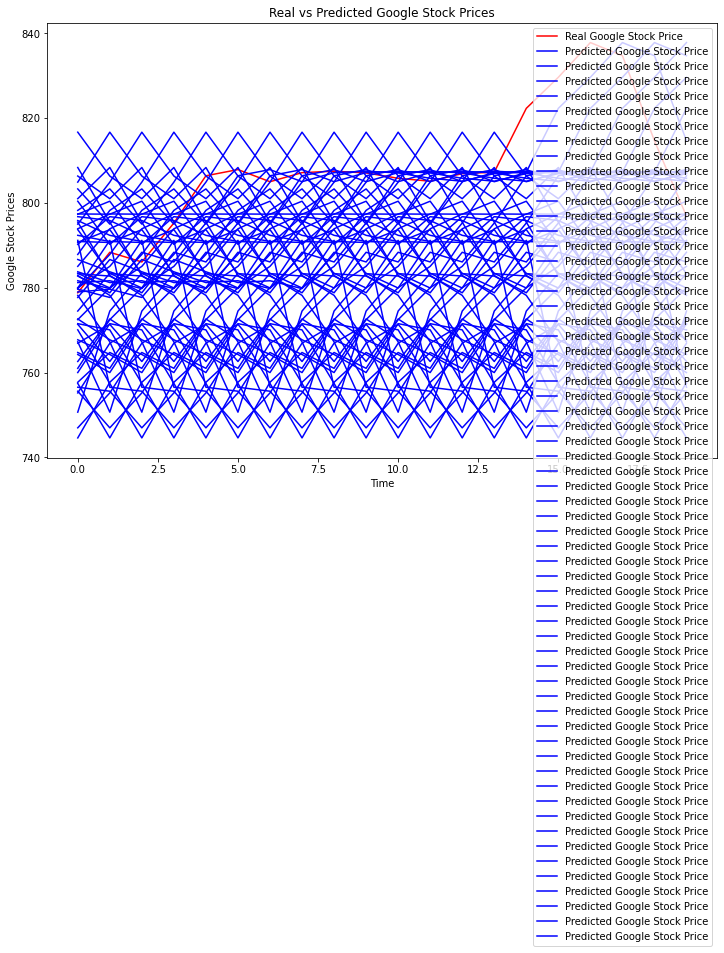

In [49]:
# Visualizing the results

plt.figure(figsize=(12,8))
plt.plot(test_set, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title("Real vs Predicted Google Stock Prices")
plt.xlabel("Time")
plt.ylabel("Google Stock Prices")
plt.legend()

### Improving the RNN

* Getting more training data: we trained our model on the past 5 years of the Google Stock Price but it would be even better to train it on the past 10 years.
* Increasing the number of timesteps: the model remembered the stock prices from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 timesteps (3 months). You could try to increase the number of timesteps, by choosing for example 120 timesteps (6 months).
* Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.
* Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.
* Adding more neurones in the LSTM layers: we highlighted the fact that we needed a high number of neurones in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurones in each of our 4 LSTM layers. You could try an architecture with even more neurones in each of the 4 (or more) LSTM layers.

### Tuning the RNN

You can do some Parameter Tuning on the RNN model we implemented. Remember, this time we are dealing with a Regression problem because we predict a continuous outcome (the Google Stock Price). Parameter Tuning for Regression is the same as Parameter Tuning for Classification which you learned in Part 1 - Artificial Neural Networks, the only difference is that you have to 

replace:
scoring = 'accuracy'  

by:
scoring = 'neg_mean_squared_error' 

in the GridSearchCV class parameters.